In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import time

print(tf.__version__)
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.initializers import RandomNormal

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Conv1DTranspose,AveragePooling1D,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D,MaxPool2D,Conv2DTranspose,AveragePooling2D,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Conv3DTranspose,AveragePooling3D,GlobalMaxPool3D,GlobalAveragePooling3D
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,Layer,BatchNormalization,Input,Add,Activation,Average



2024-11-07 01:46:20.238658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 01:46:20.238745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 01:46:20.241051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.15.0


In [2]:
#data_path = "outlineOutput"
#H:\\download\\blender\\projects\\vdmTests\\outlineOutput2"
#output_path = "H:\\tmp\\dexined"

data_path = "/media/Tomasz/4T/work/dexined/outlineOutput"
output_path = "/media/Tomasz/4T/work/dexined/tmp"


train_path = data_path + "/train/*"
edge_train_path = data_path + "/train_edge/*"

test_path = data_path + "/test/*"
edge_test_path = data_path + "/test_edge/*"

val_path = data_path + "/val/*"
edge_val_path = data_path + "/val_edge/*"

print(edge_test_path)


/media/Tomasz/4T/work/dexined/outlineOutput/test_edge/*


In [3]:
def load_data(ipath, epath):
    images = sorted(glob(os.path.join(ipath)))
    edges = sorted(glob(os.path.join(epath)))
    return images, edges

In [4]:
images, edges = load_data(train_path, edge_train_path)
valimg, valedg = load_data(val_path, edge_val_path)
print(len(images), len(valimg))

40598 4164


In [5]:
#print(len(testimg), len(testedg))

In [6]:
def read_image(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_edge(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W,H))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    x = x.astype(np.float32)
    return x

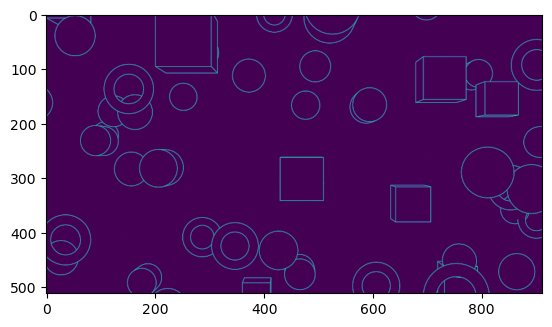

In [7]:

img = read_edge(data_path+"/train_edge/dense_000.png", H=512, W=912)
plt.imshow(img)

In [8]:
def preprocess(x,y,H=512, W=912):

    def f(x,y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_edge(y)
        return x, y

    images, edges = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([H, W, 3])
    edges.set_shape([H, W, 1])
    return images, edges

In [10]:
def tf_data(x,y,bs):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(buffer_size=bs)
    data = data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(12)
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data


In [11]:
train_data = tf_data(images, edges, len(images))
val_data = tf_data(valimg, valedg, len(valimg))

2024-11-07 01:46:56.275562: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:46:56.301084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:46:56.301297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:46:56.303126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:46:56.303331: I external/local_xla/xla/stream_executor

In [ ]:
#for x, y in train_data:
#  print(x.shape, y.shape)
#
print(len(train_data),len(val_data))


In [12]:
def pre_process_binary_cross_entropy(bc_loss,input, label, use_tf_loss=False):
    # preprocess data
    y = label
    loss = 0
    w_loss=1.0
    preds = []
    #for tmp_p in input:
    # tmp_p = input[i]
    tmp_p = input
    # loss processing
    tmp_y = tf.cast(y, dtype=tf.float32)
    mask = tf.dtypes.cast(tmp_y > 0., tf.float32)
    b,h,w,c=mask.get_shape()
    positives = tf.math.reduce_sum(mask, axis=[1, 2, 3], keepdims=True)
    negatives = h*w*c-positives

    beta2 = (1.*positives) / (negatives + positives) # negatives in hed
    beta = (1.1*negatives)/ (positives + negatives) # positives in hed
    pos_w = tf.where(tf.equal(y, 0.0), beta2, beta)
    logits = tf.sigmoid(tmp_p)

    l_cost = bc_loss(y_true=tmp_y, y_pred=logits,
                     sample_weight=pos_w)

    preds.append(logits)
    loss += (l_cost*w_loss)

    return preds, loss

In [13]:

def train(model,model_name,train_data,test_data,lr,beta1,max_epochs,batch_size):
    # Validation and Train dataset generation

    train_data = train_data
    n_train =len(train_data) #data_cache["n_files"]
    val_data = test_data
    
    # Summary and checkpoint manager
    model_dir = model_name
    summary_dir = os.path.join(output_path,'logs',model_dir)
    train_log_dir=os.path.join(summary_dir,'train')
    val_log_dir =os.path.join(summary_dir,'test')

    checkpoint_dir = os.path.join(output_path,"checkpoint_dir",model_dir)
    epoch_ckpt_dir = checkpoint_dir + 'epochs'
    os.makedirs(epoch_ckpt_dir, exist_ok=True)
    os.makedirs(train_log_dir,exist_ok=True)
    os.makedirs(val_log_dir,exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    train_writer = tf.summary.create_file_writer(train_log_dir)
    val_writer = tf.summary.create_file_writer(val_log_dir)

    my_model = model

    # accuracy = metrics.SparseCategoricalAccuracy()
    accuracy = metrics.BinaryAccuracy()
    accuracy_val = metrics.BinaryAccuracy()
    loss_bc = losses.BinaryCrossentropy()
    optimizer = optimizers.Adam(
        learning_rate=lr, beta_1=beta1)
    iter = 0

    imgs_res_folder = os.path.join(output_path,model_dir, "current_training")
    os.makedirs(imgs_res_folder, exist_ok=True)
    global_loss = 1000.
    t_loss = []
    ckpt_save_mode = "h5"
    tmp_lr = lr
    for epoch in range(max_epochs):
        # training
        t_loss = []
        # if epoch in self.args.adjust_lr:
        tmp_lr=tmp_lr*0.1
        optimizer.lr.assign(tmp_lr)
        for step, (x, y) in enumerate(train_data):

            with tf.GradientTape() as tape:
                pred = my_model(x, training=True)

                preds, loss = pre_process_binary_cross_entropy(
                    loss_bc, pred, y, use_tf_loss=False)

            accuracy.update_state(y_true=y, y_pred=preds[-1])
            gradients = tape.gradient(loss, my_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))

            # logging the current accuracy value so far.
            t_loss.append(loss.numpy())
            if step % 10 == 0:
                print("Epoch:", epoch, "Step:", step, "Loss: %.4f" % loss.numpy(),
                        "Accuracy: %.4f" % accuracy.result(), time.ctime())

            #if step % 10 == 0:
            #    # visualize preds
            #    img_test = 'Epoch: {0} Sample {1}/{2} Loss: {3}' \
            #        .format(epoch, step, n_train // batch_size, loss.numpy())
            #    vis_imgs = visualize_result(
            #        x=x[2], y=y[2], p=preds, img_title=img_test)
            #    cv.imwrite(os.path.join(imgs_res_folder, 'results.png'), vis_imgs)
            if step % 20 == 0 and loss < global_loss:  # 500
                if epoch==0 and step==0:
                    tmp_loss = np.array(t_loss)
                    with train_writer.as_default():
                        tf.summary.scalar('loss', tmp_loss.mean(), step=epoch)
                        tf.summary.scalar('accuracy', accuracy.result(), step=epoch)

                save_ckpt_path = os.path.join(checkpoint_dir, "DexiNedL_model.h5")
                Model.save_weights(my_model, save_ckpt_path, save_format='h5')

                global_loss = loss
                print("Model saved in:  ", save_ckpt_path, "Current loss:", global_loss.numpy())

            iter += 1  # global iteration

        t_loss = np.array(t_loss)
        # train summary
        if epoch!=0:
            with train_writer.as_default():
                tf.summary.scalar('loss', t_loss.mean(), step=epoch)
                tf.summary.scalar('accuracy', accuracy.result(), step=epoch)

        Model.save_weights(my_model, os.path.join(epoch_ckpt_dir, "DexiNed{}_model.h5".format(str(epoch))),
                            save_format=ckpt_save_mode)
        print("Epoch:", epoch, "Model saved in Loss: ", t_loss.mean())

        # validation
        t_val_loss = []
        for i, (x_val, y_val) in enumerate(val_data):

            pred_val = my_model(x_val)
            v_logits, V_loss = pre_process_binary_cross_entropy(
                loss_bc, pred_val, y_val, use_tf_loss=False)
            accuracy_val.update_state(y_true=y_val, y_pred=v_logits[-1])
            t_val_loss.append(V_loss.numpy())
            if i == 7:
                break
        val_acc = accuracy_val.result()
        t_val_loss = np.array(t_val_loss)
        print("Epoch(validation):", epoch, "Val loss: ", t_val_loss.mean(),
                "Accuracy: ", val_acc.numpy())
        # validation summary
        with val_writer.as_default():
            tf.summary.scalar('loss', t_val_loss.mean(), step=epoch)
            tf.summary.scalar('accuracy', val_acc.numpy(), step=epoch)

        # Reset metrics every epoch
        accuracy.reset_states()
        accuracy_val.reset_states()

    my_model.summary()


In [14]:
weight_init = tf.initializers.glorot_uniform()

l2 = regularizers.l2
w_decay=1e-3

glorot_normal = RandomNormal(stddev=0.01)

In [15]:
self_conv2D_3 = Conv2D(32 , kernel_size=(3,3),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_batchnormalization_24 = BatchNormalization()
self_conv2D_40 = Conv2D(64 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_batchnormalization_18 = BatchNormalization()
self_activation_11 = Activation(activation='relu')
self_conv2D_1 = Conv2D(128 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_16 = Conv2D(128 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_51 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_1 = BatchNormalization()
self_transpoze2D_9 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same')
self_conv2D_49 = Conv2D(128 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_8 = BatchNormalization()
self_activation_1 = Activation(activation='relu')
self_conv2D_17 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_maxpool2D_1 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_transpoze2D_10 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same')
self_conv2D_28 = Conv2D(256 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_36 = Conv2D(256 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_activation_8 = Activation(activation='relu')
self_conv2D_47 = Conv2D(256 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_48 = Conv2D(512 , kernel_size=(1,1),strides=(2,2),padding = 'same')
self_conv2D_33 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_6 = BatchNormalization()
self_activation_9 = Activation(activation='relu')
self_conv2D_31 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_22 = BatchNormalization()
self_activation_6 = Activation(activation='relu')
self_conv2D_30 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_4 = BatchNormalization()
self_activation_7 = Activation(activation='relu')
self_conv2D_18 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_20 = BatchNormalization()
self_conv2D_38 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_maxpool2D_2 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_transpoze2D_15 = Conv2DTranspose(16 , kernel_size=(4,4),strides=(2,2),padding = 'same')
self_conv2D_11 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_34 = Conv2D(512 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_50 = Conv2D(512 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_2 = Conv2DTranspose(1 , kernel_size=(4,4),strides=(2,2),padding = 'same')
self_activation_10 = Activation(activation='relu')
self_conv2D_32 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_10 = BatchNormalization()
self_activation_5 = Activation(activation='relu')
self_conv2D_27 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_19 = BatchNormalization()
self_activation_24 = Activation(activation='relu')
self_conv2D_26 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_13 = BatchNormalization()
self_activation_16 = Activation(activation='relu')
self_conv2D_13 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_17 = BatchNormalization()
self_activation_22 = Activation(activation='relu')
self_conv2D_29 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_15 = BatchNormalization()
self_activation_23 = Activation(activation='relu')
self_conv2D_24 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_12 = BatchNormalization()
self_conv2D_44 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_maxpool2D_3 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_transpoze2D_7 = Conv2DTranspose(16 , kernel_size=(8,8),strides=(2,2),padding = 'same')
self_conv2D_45 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_activation_15 = Activation(activation='relu')
self_conv2D_6 = Conv2D(512 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_2 = Conv2D(512 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_8 = Conv2DTranspose(16 , kernel_size=(8,8),strides=(2,2),padding = 'same')
self_conv2D_43 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_41 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_7 = BatchNormalization()
self_transpoze2D_14 = Conv2DTranspose(1 , kernel_size=(8,8),strides=(2,2),padding = 'same')
self_activation_17 = Activation(activation='relu')
self_conv2D_19 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_16 = BatchNormalization()
self_activation_13 = Activation(activation='relu')
self_conv2D_21 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_14 = BatchNormalization()
self_activation_14 = Activation(activation='relu')
self_conv2D_15 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_5 = BatchNormalization()
self_activation_18 = Activation(activation='relu')
self_conv2D_14 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_26 = BatchNormalization()
self_activation_19 = Activation(activation='relu')
self_conv2D_5 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_3 = BatchNormalization()
self_conv2D_8 = Conv2D(256 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_35 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_activation_20 = Activation(activation='relu')
self_transpoze2D_4 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_22 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_12 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_11 = BatchNormalization()
self_transpoze2D_12 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_activation_21 = Activation(activation='relu')
self_conv2D_37 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_10 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_5 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_batchnormalization_21 = BatchNormalization()
self_conv2D_42 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_13 = Conv2DTranspose(1 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_activation_3 = Activation(activation='relu')
self_conv2D_20 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_9 = BatchNormalization()
self_activation_4 = Activation(activation='relu')
self_conv2D_23 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_2 = BatchNormalization()
self_activation_2 = Activation(activation='relu')
self_conv2D_7 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_23 = BatchNormalization()
self_activation_12 = Activation(activation='relu')
self_conv2D_25 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_25 = BatchNormalization()
self_conv2D_39 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_11 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_4 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_3 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_9 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_6 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_46 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_1 = Conv2DTranspose(1 , kernel_size=(16,16),strides=(2,2),padding = 'same')
#self_block_cat = SingleConvBlock(
#    1,k_size=(1,1),stride=(1,1),
#    w_init=tf.constant_initializer(1/5))

self_last_conv = Conv2D(1, kernel_size=(1,1), strides=(1,1), padding = 'same', kernel_initializer=tf.constant_initializer(1/5))
self_last_batchnormalization = BatchNormalization()
self_last_activation = Activation(activation='relu')

#-------------------------------------

x = Input(shape=(512,912,3))
conv2D_3 = self_conv2D_3(x)
batchnormalization_24 = self_batchnormalization_24(conv2D_3)
conv2D_40 = self_conv2D_40(batchnormalization_24)
batchnormalization_18 = self_batchnormalization_18(conv2D_40)
activation_11 = self_activation_11(batchnormalization_18)
conv2D_1 = self_conv2D_1(activation_11)
conv2D_16 = self_conv2D_16(activation_11)
conv2D_51 = self_conv2D_51(activation_11)
batchnormalization_1 = self_batchnormalization_1(conv2D_1)
transpoze2D_9 = self_transpoze2D_9(conv2D_51)
conv2D_49 = self_conv2D_49(batchnormalization_1)
batchnormalization_8 = self_batchnormalization_8(conv2D_49)
activation_1 = self_activation_1(batchnormalization_8)
conv2D_17 = self_conv2D_17(activation_1)
maxpool2D_1 = self_maxpool2D_1(activation_1)
transpoze2D_10 = self_transpoze2D_10(conv2D_17)
add_1 = Add()([conv2D_16,maxpool2D_1])
conv2D_28 = self_conv2D_28(maxpool2D_1)
conv2D_36 = self_conv2D_36(maxpool2D_1)
activation_8 = self_activation_8(add_1)
conv2D_47 = self_conv2D_47(add_1)
conv2D_48 = self_conv2D_48(conv2D_36)
conv2D_33 = self_conv2D_33(activation_8)
batchnormalization_6 = self_batchnormalization_6(conv2D_33)
activation_9 = self_activation_9(batchnormalization_6)
conv2D_31 = self_conv2D_31(activation_9)
batchnormalization_22 = self_batchnormalization_22(conv2D_31)
average_5 = Average()([batchnormalization_22,conv2D_28])
activation_6 = self_activation_6(average_5)
conv2D_30 = self_conv2D_30(activation_6)
batchnormalization_4 = self_batchnormalization_4(conv2D_30)
activation_7 = self_activation_7(batchnormalization_4)
conv2D_18 = self_conv2D_18(activation_7)
batchnormalization_20 = self_batchnormalization_20(conv2D_18)
average_4 = Average()([batchnormalization_20,conv2D_28])
conv2D_38 = self_conv2D_38(average_4)
maxpool2D_2 = self_maxpool2D_2(average_4)
transpoze2D_15 = self_transpoze2D_15(conv2D_38)
add_2 = Add()([conv2D_47,maxpool2D_2])
add_4 = Add()([conv2D_36,maxpool2D_2])
conv2D_11 = self_conv2D_11(transpoze2D_15)
conv2D_34 = self_conv2D_34(add_2)
conv2D_50 = self_conv2D_50(add_4)
transpoze2D_2 = self_transpoze2D_2(conv2D_11)
activation_10 = self_activation_10(add_2)
conv2D_32 = self_conv2D_32(activation_10)
batchnormalization_10 = self_batchnormalization_10(conv2D_32)
activation_5 = self_activation_5(batchnormalization_10)
conv2D_27 = self_conv2D_27(activation_5)
batchnormalization_19 = self_batchnormalization_19(conv2D_27)
average_3 = Average()([batchnormalization_19,conv2D_50])
activation_24 = self_activation_24(average_3)
conv2D_26 = self_conv2D_26(activation_24)
batchnormalization_13 = self_batchnormalization_13(conv2D_26)
activation_16 = self_activation_16(batchnormalization_13)
conv2D_13 = self_conv2D_13(activation_16)
batchnormalization_17 = self_batchnormalization_17(conv2D_13)
average_2 = Average()([batchnormalization_17,conv2D_50])
activation_22 = self_activation_22(average_2)
conv2D_29 = self_conv2D_29(activation_22)
batchnormalization_15 = self_batchnormalization_15(conv2D_29)
activation_23 = self_activation_23(batchnormalization_15)
conv2D_24 = self_conv2D_24(activation_23)
batchnormalization_12 = self_batchnormalization_12(conv2D_24)
average_11 = Average()([batchnormalization_12,conv2D_50])
conv2D_44 = self_conv2D_44(average_11)
maxpool2D_3 = self_maxpool2D_3(average_11)
transpoze2D_7 = self_transpoze2D_7(conv2D_44)
add_3 = Add()([conv2D_34,maxpool2D_3])
add_5 = Add()([conv2D_48,maxpool2D_3])
conv2D_45 = self_conv2D_45(transpoze2D_7)
activation_15 = self_activation_15(add_3)
conv2D_6 = self_conv2D_6(add_3)
conv2D_2 = self_conv2D_2(add_5)
transpoze2D_8 = self_transpoze2D_8(conv2D_45)
conv2D_43 = self_conv2D_43(activation_15)
conv2D_41 = self_conv2D_41(transpoze2D_8)
batchnormalization_7 = self_batchnormalization_7(conv2D_43)
transpoze2D_14 = self_transpoze2D_14(conv2D_41)
activation_17 = self_activation_17(batchnormalization_7)
conv2D_19 = self_conv2D_19(activation_17)
batchnormalization_16 = self_batchnormalization_16(conv2D_19)
average_7 = Average()([batchnormalization_16,conv2D_2])
activation_13 = self_activation_13(average_7)
conv2D_21 = self_conv2D_21(activation_13)
batchnormalization_14 = self_batchnormalization_14(conv2D_21)
activation_14 = self_activation_14(batchnormalization_14)
conv2D_15 = self_conv2D_15(activation_14)
batchnormalization_5 = self_batchnormalization_5(conv2D_15)
average_6 = Average()([batchnormalization_5,conv2D_2])
activation_18 = self_activation_18(average_6)
conv2D_14 = self_conv2D_14(activation_18)
batchnormalization_26 = self_batchnormalization_26(conv2D_14)
activation_19 = self_activation_19(batchnormalization_26)
conv2D_5 = self_conv2D_5(activation_19)
batchnormalization_3 = self_batchnormalization_3(conv2D_5)
average_1 = Average()([batchnormalization_3,conv2D_2])
add_6 = Add()([average_1,conv2D_6])
conv2D_8 = self_conv2D_8(average_1)
conv2D_35 = self_conv2D_35(average_1)
activation_20 = self_activation_20(add_6)
transpoze2D_4 = self_transpoze2D_4(conv2D_35)
conv2D_22 = self_conv2D_22(activation_20)
conv2D_12 = self_conv2D_12(transpoze2D_4)
batchnormalization_11 = self_batchnormalization_11(conv2D_22)
transpoze2D_12 = self_transpoze2D_12(conv2D_12)
activation_21 = self_activation_21(batchnormalization_11)
conv2D_37 = self_conv2D_37(transpoze2D_12)
conv2D_10 = self_conv2D_10(activation_21)
transpoze2D_5 = self_transpoze2D_5(conv2D_37)
batchnormalization_21 = self_batchnormalization_21(conv2D_10)
conv2D_42 = self_conv2D_42(transpoze2D_5)
average_10 = Average()([batchnormalization_21,conv2D_8])
transpoze2D_13 = self_transpoze2D_13(conv2D_42)
activation_3 = self_activation_3(average_10)
conv2D_20 = self_conv2D_20(activation_3)
batchnormalization_9 = self_batchnormalization_9(conv2D_20)
activation_4 = self_activation_4(batchnormalization_9)
conv2D_23 = self_conv2D_23(activation_4)
batchnormalization_2 = self_batchnormalization_2(conv2D_23)
average_9 = Average()([batchnormalization_2,conv2D_8])
activation_2 = self_activation_2(average_9)
conv2D_7 = self_conv2D_7(activation_2)
batchnormalization_23 = self_batchnormalization_23(conv2D_7)
activation_12 = self_activation_12(batchnormalization_23)
conv2D_25 = self_conv2D_25(activation_12)
batchnormalization_25 = self_batchnormalization_25(conv2D_25)
average_8 = Average()([batchnormalization_25,conv2D_8])
conv2D_39 = self_conv2D_39(average_8)
transpoze2D_11 = self_transpoze2D_11(conv2D_39)
conv2D_4 = self_conv2D_4(transpoze2D_11)
transpoze2D_3 = self_transpoze2D_3(conv2D_4)
conv2D_9 = self_conv2D_9(transpoze2D_3)
transpoze2D_6 = self_transpoze2D_6(conv2D_9)
conv2D_46 = self_conv2D_46(transpoze2D_6)
transpoze2D_1 = self_transpoze2D_1(conv2D_46)
#tmp = [transpoze2D_1,transpoze2D_2,transpoze2D_9,transpoze2D_10,transpoze2D_13,transpoze2D_14]
tmp = [transpoze2D_9,transpoze2D_10,transpoze2D_2,transpoze2D_14,transpoze2D_13,transpoze2D_1]

#-----------
#concatenate_1 = tf.concat(tmp,3)
#-----------
#concat_lambda = lambda xs: tf.concat(xs, axis=3)
#concatenate_1 = tf.keras.layers.Lambda(concat_lambda)(tmp,3)
#-----------
self_concatenate_1 = Concatenate(axis=3)
concatenate_1 = self_concatenate_1(tmp)

#print(f"concatenate_1 shape: {concatenate_1.shape}")
#return concatenate_1

#results = [transpoze2D_1,transpoze2D_2,transpoze2D_9,transpoze2D_10,transpoze2D_13,transpoze2D_14]
#block_cat = tf.concat(results, 3)  # BxHxWX6
#print(f"CONCATENATE_1 shape: {block_cat.shape}")
#block_cat = self_block_cat(block_cat)  # BxHxWX1
#results.append(block_cat)


last_conv =self_last_conv(concatenate_1)
last_batchnormalization = self_last_batchnormalization(last_conv)
last_activation = self_last_activation(last_batchnormalization)
#concatenate_1 = Concatenate()([transpoze2D_1,transpoze2D_3,transpoze2D_4,transpoze2D_7,transpoze2D_8,transpoze2D_10])




model = Model(inputs =x , outputs=last_activation)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
#model.summary()

In [17]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam", run_eagerly=True) #,
    #metrics=[tf.keras.metrics.BinaryAccuracy(),
     #        tf.keras.metrics.FalseNegatives(),
      #       tf.keras.metrics.FalsePositives(),
       #      tf.keras.metrics.TruePositives(),
        #    tf.keras.metrics.TrueNegatives()])

In [18]:
train(model,"dexined_try",train_data,val_data,0.0001,0.5,11,12)

2024-11-07 01:47:27.296058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 8904
2024-11-07 01:47:35.309181: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 342.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-07 01:47:35.309435: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 342.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-07 01:47:35.309532: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 342.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there co

ResourceExhaustedError: Exception encountered when calling layer 'conv2d_2' (type Conv2D).

{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[12,256,456,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:BiasAdd] name: 

Call arguments received by layer 'conv2d_2' (type Conv2D):
  • inputs=tf.Tensor(shape=(12, 256, 456, 64), dtype=float32)

Epoch: 6 Step: 270 Loss: 0.3419 Accuracy: 0.6348 Tue Nov  5 01:33:13 2024
Epoch: 6 Step: 280 Loss: 0.3389 Accuracy: 0.6348 Tue Nov  5 01:33:17 2024
Epoch: 6 Step: 290 Loss: 0.3406 Accuracy: 0.6348 Tue Nov  5 01:33:20 2024
Epoch: 6 Step: 300 Loss: 0.3388 Accuracy: 0.6348 Tue Nov  5 01:33:24 2024
Epoch: 6 Step: 310 Loss: 0.3431 Accuracy: 0.6348 Tue Nov  5 01:33:27 2024
Epoch: 6 Step: 320 Loss: 0.3364 Accuracy: 0.6349 Tue Nov  5 01:33:31 2024
Epoch: 6 Step: 330 Loss: 0.3405 Accuracy: 0.6349 Tue Nov  5 01:33:35 2024
Epoch: 6 Step: 340 Loss: 0.3395 Accuracy: 0.6348 Tue Nov  5 01:33:38 2024
Epoch: 6 Step: 350 Loss: 0.3388 Accuracy: 0.6349 Tue Nov  5 01:33:42 2024
Epoch: 6 Step: 360 Loss: 0.3393 Accuracy: 0.6349 Tue Nov  5 01:33:45 2024
Epoch: 6 Step: 370 Loss: 0.3401 Accuracy: 0.6348 Tue Nov  5 01:33:49 2024
Epoch: 6 Step: 380 Loss: 0.3412 Accuracy: 0.6348 Tue Nov  5 01:33:53 2024
Epoch: 6 Step: 390 Loss: 0.3392 Accuracy: 0.6348 Tue Nov  5 01:33:56 2024
Epoch: 6 Step: 400 Loss: 0.3395 Accura

Epoch: 7 Step: 330 Loss: 0.3397 Accuracy: 0.6348 Tue Nov  5 01:39:52 2024
Epoch: 7 Step: 340 Loss: 0.3406 Accuracy: 0.6348 Tue Nov  5 01:39:55 2024
Epoch: 7 Step: 350 Loss: 0.3411 Accuracy: 0.6349 Tue Nov  5 01:39:59 2024
Epoch: 7 Step: 360 Loss: 0.3406 Accuracy: 0.6349 Tue Nov  5 01:40:02 2024
Epoch: 7 Step: 370 Loss: 0.3406 Accuracy: 0.6348 Tue Nov  5 01:40:06 2024
Epoch: 7 Step: 380 Loss: 0.3422 Accuracy: 0.6348 Tue Nov  5 01:40:10 2024
Epoch: 7 Step: 390 Loss: 0.3409 Accuracy: 0.6348 Tue Nov  5 01:40:13 2024
Epoch: 7 Step: 400 Loss: 0.3412 Accuracy: 0.6348 Tue Nov  5 01:40:17 2024
Epoch: 7 Step: 410 Loss: 0.3407 Accuracy: 0.6348 Tue Nov  5 01:40:21 2024
Epoch: 7 Step: 420 Loss: 0.3417 Accuracy: 0.6348 Tue Nov  5 01:40:24 2024
Epoch: 7 Step: 430 Loss: 0.3380 Accuracy: 0.6348 Tue Nov  5 01:40:28 2024
Epoch: 7 Step: 440 Loss: 0.3393 Accuracy: 0.6348 Tue Nov  5 01:40:32 2024
Epoch: 7 Step: 450 Loss: 0.3427 Accuracy: 0.6348 Tue Nov  5 01:40:35 2024
Epoch: 7 Step: 460 Loss: 0.3405 Accura

Epoch: 8 Step: 390 Loss: 0.3407 Accuracy: 0.6347 Tue Nov  5 01:46:34 2024
Epoch: 8 Step: 400 Loss: 0.3398 Accuracy: 0.6347 Tue Nov  5 01:46:38 2024
Epoch: 8 Step: 410 Loss: 0.3386 Accuracy: 0.6348 Tue Nov  5 01:46:41 2024
Epoch: 8 Step: 420 Loss: 0.3416 Accuracy: 0.6348 Tue Nov  5 01:46:45 2024
Epoch: 8 Step: 430 Loss: 0.3399 Accuracy: 0.6347 Tue Nov  5 01:46:48 2024
Epoch: 8 Step: 440 Loss: 0.3407 Accuracy: 0.6347 Tue Nov  5 01:46:52 2024
Epoch: 8 Step: 450 Loss: 0.3404 Accuracy: 0.6347 Tue Nov  5 01:46:56 2024
Epoch: 8 Step: 460 Loss: 0.3381 Accuracy: 0.6347 Tue Nov  5 01:46:59 2024
Epoch: 8 Step: 470 Loss: 0.3414 Accuracy: 0.6347 Tue Nov  5 01:47:03 2024
Epoch: 8 Step: 480 Loss: 0.3421 Accuracy: 0.6347 Tue Nov  5 01:47:07 2024
Epoch: 8 Step: 490 Loss: 0.3415 Accuracy: 0.6347 Tue Nov  5 01:47:10 2024
Epoch: 8 Step: 500 Loss: 0.3388 Accuracy: 0.6347 Tue Nov  5 01:47:14 2024
Epoch: 8 Step: 510 Loss: 0.3412 Accuracy: 0.6347 Tue Nov  5 01:47:18 2024
Epoch: 8 Step: 520 Loss: 0.3374 Accura

Epoch: 9 Step: 450 Loss: 0.3391 Accuracy: 0.6347 Tue Nov  5 01:53:14 2024
Epoch: 9 Step: 460 Loss: 0.3414 Accuracy: 0.6347 Tue Nov  5 01:53:17 2024
Epoch: 9 Step: 470 Loss: 0.3405 Accuracy: 0.6347 Tue Nov  5 01:53:21 2024
Epoch: 9 Step: 480 Loss: 0.3393 Accuracy: 0.6347 Tue Nov  5 01:53:24 2024
Epoch: 9 Step: 490 Loss: 0.3392 Accuracy: 0.6347 Tue Nov  5 01:53:28 2024
Epoch: 9 Step: 500 Loss: 0.3426 Accuracy: 0.6347 Tue Nov  5 01:53:32 2024
Epoch: 9 Step: 510 Loss: 0.3421 Accuracy: 0.6347 Tue Nov  5 01:53:35 2024
Epoch: 9 Step: 520 Loss: 0.3407 Accuracy: 0.6347 Tue Nov  5 01:53:39 2024
Epoch: 9 Step: 530 Loss: 0.3392 Accuracy: 0.6347 Tue Nov  5 01:53:42 2024
Epoch: 9 Step: 540 Loss: 0.3383 Accuracy: 0.6347 Tue Nov  5 01:53:46 2024
Epoch: 9 Step: 550 Loss: 0.3432 Accuracy: 0.6347 Tue Nov  5 01:53:50 2024
Epoch: 9 Step: 560 Loss: 0.3410 Accuracy: 0.6347 Tue Nov  5 01:53:53 2024
Epoch: 9 Step: 570 Loss: 0.3387 Accuracy: 0.6347 Tue Nov  5 01:53:57 2024
Epoch: 9 Step: 580 Loss: 0.3415 Accura

Epoch: 10 Step: 500 Loss: 0.3398 Accuracy: 0.6347 Tue Nov  5 01:59:48 2024
Epoch: 10 Step: 510 Loss: 0.3406 Accuracy: 0.6347 Tue Nov  5 01:59:52 2024
Epoch: 10 Step: 520 Loss: 0.3415 Accuracy: 0.6347 Tue Nov  5 01:59:56 2024
Epoch: 10 Step: 530 Loss: 0.3403 Accuracy: 0.6347 Tue Nov  5 01:59:59 2024
Epoch: 10 Step: 540 Loss: 0.3392 Accuracy: 0.6347 Tue Nov  5 02:00:03 2024
Epoch: 10 Step: 550 Loss: 0.3405 Accuracy: 0.6347 Tue Nov  5 02:00:06 2024
Epoch: 10 Step: 560 Loss: 0.3402 Accuracy: 0.6347 Tue Nov  5 02:00:10 2024
Epoch: 10 Step: 570 Loss: 0.3402 Accuracy: 0.6348 Tue Nov  5 02:00:14 2024
Epoch: 10 Step: 580 Loss: 0.3410 Accuracy: 0.6348 Tue Nov  5 02:00:17 2024
Epoch: 10 Step: 590 Loss: 0.3431 Accuracy: 0.6348 Tue Nov  5 02:00:21 2024
Epoch: 10 Step: 600 Loss: 0.3394 Accuracy: 0.6348 Tue Nov  5 02:00:24 2024
Epoch: 10 Step: 610 Loss: 0.3399 Accuracy: 0.6348 Tue Nov  5 02:00:28 2024
Epoch: 10 Step: 620 Loss: 0.3394 Accuracy: 0.6348 Tue Nov  5 02:00:32 2024
Epoch: 10 Step: 630 Loss:

                                                                                                  
 add (Add)                      (None, 128, 228, 12  0           ['conv2d_3[0][0]',               
                                8)                                'max_pooling2d[0][0]']          
                                                                                                  
 activation_2 (Activation)      (None, 128, 228, 12  0           ['add[0][0]']                    
                                8)                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 128, 228, 25  295168      ['activation_2[0][0]']           
                                6)                                                                
                                                                                                  
 batch_nor

                                )                                                                 
                                                                                                  
 average_2 (Average)            (None, 64, 114, 512  0           ['batch_normalization_9[0][0]',  
                                )                                 'conv2d_18[0][0]']              
                                                                                                  
 activation_8 (Activation)      (None, 64, 114, 512  0           ['average_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 64, 114, 512  2359808     ['activation_8[0][0]']           
                                )                                                                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 32, 57, 512)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 57, 512)  2359808     ['activation_15[0][0]']          
                                                                                                  
 batch_normalization_17 (BatchN  (None, 32, 57, 512)  2048       ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 average_6 (Average)            (None, 32, 57, 512)  0           ['batch_normalization_17[0][0]', 
          

                                                                                                  
 average_10 (Average)           (None, 32, 57, 256)  0           ['batch_normalization_25[0][0]', 
                                                                  'conv2d_36[0][0]']              
                                                                                                  
 conv2d_37 (Conv2D)             (None, 32, 57, 16)   8208        ['average_7[0][0]']              
                                                                                                  
 conv2d_47 (Conv2D)             (None, 32, 57, 16)   4112        ['average_10[0][0]']             
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 64, 114, 16)  65552      ['conv2d_37[0][0]']              
 spose)                                                                                           
          

                                                                                                  
 concatenate (Concatenate)      (None, 512, 912, 6)  0           ['conv2d_transpose[0][0]',       
                                                                  'conv2d_transpose_1[0][0]',     
                                                                  'conv2d_transpose_3[0][0]',     
                                                                  'conv2d_transpose_6[0][0]',     
                                                                  'conv2d_transpose_10[0][0]',    
                                                                  'conv2d_transpose_14[0][0]']    
                                                                                                  
 conv2d_51 (Conv2D)             (None, 512, 912, 1)  7           ['concatenate[0][0]']            
                                                                                                  
 batch_nor

In [ ]:
img_pre = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test\\dense_981.png')
img = np.expand_dims(img_pre, axis=0)
plt.imshow(img_pre)

In [ ]:
img_e = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test_edge\\dense_981.png')
#img = np.expand_dims(img, axis=0)
plt.imshow(img_e)

In [ ]:
#model.load_weights("H:\\tmp\\dexined\\checkpoint_dir\\dexined_tryepochs\\DexiNed10_model.h5")
res_pre = model.predict(img)
res = res_pre[-1,:,:]
plt.imshow(res)

In [ ]:
def image_normalization(img, img_min=0, img_max=255):
    """This is a typical image normalization function
    where the minimum and maximum of the image is needed
    source: https://en.wikipedia.org/wiki/Normalization_(image_processing)
    :param img: an image could be gray scale or color
    :param img_min:  for default is 0
    :param img_max: for default is 255
    :return: a normalized image, if max is 255 the dtype is uint8
    """
    img = np.float32(img)
    epsilon=1e-12 # whenever an inconsistent image
    img = (img-np.min(img))*(img_max-img_min)/((np.max(img)-np.min(img))+epsilon)+img_min
    return img

In [ ]:
import cv2
res2=res
res2[res2 < 0.0] = 0.0
out=cv2.bitwise_not(np.uint8(image_normalization(res2)))
plt.imshow(out, cmap='gray')

In [ ]:
#train_steps=len(train_data)
#val_steps=len(test_data)
#print(train_steps)
#model.fit(train_data, validation_data=test_data, epochs=2, steps_per_epoch=train_steps, validation_steps=val_steps)

In [ ]:
model.save('./DexiNed_batchSize4.h5')
img_pre = read_image('outlineOutput/val_edge/dense_981.png')
img = np.expand_dims(img_pre, axis=0)
#plt.imshow(img_e)
res_pre = model.predict(img)
res = res_pre[-1,:,:]
plt.imshow(res)

In [ ]:
model.fit(train_data, validation_data=test_data, epochs=8, steps_per_epoch=train_steps, validation_steps=val_steps)

In [ ]:
#model.save('./DexiNed.h5')
model.save('./DexiNed_train-21K_test-2K_epoch10_batchsize16.h5')

In [ ]:
img_pre = read_image('outlineOutput/val/dense_981.png')
img = np.expand_dims(img_pre, axis=0)
plt.imshow(img_pre)

In [ ]:
img_e = read_image('outlineOutput/val_edge/dense_981.png')
#img = np.expand_dims(img, axis=0)
plt.imshow(img_e)

In [ ]:
res = model.predict(img)

In [ ]:
res = res[-1,:,:]
plt.imshow(res)

In [ ]:

img_pre = read_image('BIPED/edges/imgs/train/rgbr/real/RGB_258.jpg')
imgg = np.expand_dims(img_pre, axis=0)
plt.imshow(img_pre)

In [ ]:

edge_pre = read_image('BIPED/edges/edge_maps/train/rgbr/real/RGB_258.png')
#imgg = np.expand_dims(edge_pre, axis=0)
plt.imshow(edge_pre)

In [ ]:
res = model.predict(imgg)
res = res[-1,:,:]


In [ ]:
plt.imshow(res)

In [ ]:
#DexiNed_train-21K_test-2K_epoch8_batchsize16
model8epoch = tf.keras.models.load_model("DexiNed_train-21K_test-2K_epoch8_batchsize16.h5")
img_pre = read_image('outlineOutput/val/dense_981.png')
img = np.expand_dims(img_pre, axis=0)
res = model8epoch.predict(img)
res = res[-1,:,:]
plt.imshow(res)

In [ ]:

img_pre = read_image('BIPED/edges/imgs/train/rgbr/real/RGB_258.jpg')
imgg = np.expand_dims(img_pre, axis=0)
resg = model8epoch.predict(imgg)
resg = resg[-1,:,:]
plt.imshow(resg)

In [ ]:

print(model8epoch.optimizer.iterations)

In [ ]:
model8epoch.fit(train_data, validation_data=test_data, epochs=10, steps_per_epoch=train_steps, validation_steps=val_steps)

model.save('./DexiNed_train-21K_test-2K_epoch20_batchsize16.h5')

model.save('./DexiNed_train-21K_test-2K_epoch20_batchsize16.h5')


In [ ]:
img_pre = read_image('BIPED/edges/imgs/train/rgbr/real/RGB_258.jpg')
resg = model8epoch.predict(imgg)
resg = resg[-1,:,:]
plt.imshow(resg)

In [ ]:
img_pre = read_image('outlineOutput/val/dense_981.png')
img = np.expand_dims(img_pre, axis=0)
res = model8epoch.predict(img)
res = res[-1,:,:]
plt.imshow(res)

In [ ]:
img_pre = read_image('outlineOutput/val/hyl4.jpg')
img = np.expand_dims(img_pre, axis=0)
res = model8epoch.predict(img)
res = res[-1,:,:]
plt.imshow(res)